## Importing All Necessary Libraries :

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [53]:
file_path=os.path.join(os.path.dirname(os.getcwd()),'data','preprocessed_data','processed_df.csv')
try:
    if os.path.exists(file_path) is not True :
        raise FileNotFoundError(f'The required file path is not found : {file_path}')
    df=pd.read_csv(file_path)
    print('Dataset Loaded Succesfully ...')
    print(f'Dataset have : {df.shape[0] } rows and {df.shape[1]} columns.')
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f'Unexpected error is occcured :{str(e)}')

Dataset Loaded Succesfully ...
Dataset have : 149481 rows and 14 columns.


In [8]:
df

,AGENCY NAME,CLASS TITLE,ETHNICITY,GENDER,STATUS,HRLY RATE,HRS PER WK,MONTHLY,ANNUAL,EMPLOY_YEAR,TENURE,is_hourly,AGENCY_FREQ,CLASS_TITLE_FREQ
0,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECTION","JUDGE, RETIRED",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,75.96150,29.0,9545.82,114549.84,1988,37,1,1033,324
1,OFFICE OF COURT ADMINISTRATION,GENERAL COUNSEL IV,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,81.04454,4.0,1404.77,16857.24,2015,10,1,266,47
2,"COMPTROLLER OF PUBLIC ACCOUNTS, JUDICIARY SECTION","JUDGE, RETIRED",WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,75.96150,29.0,9545.82,114549.84,2020,5,1,1033,324
3,OFFICE OF COURT ADMINISTRATION,GENERAL COUNSEL IV,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,81.04453,4.0,1404.77,16857.24,2018,7,1,266,47
4,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,CORREC OFFICER IV,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.00000,40.0,3284.27,39411.24,2020,5,0,35926,9267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149476,STATE PRESERVATION BOARD,SECURITY OFFICER III,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.00000,40.0,2899.00,34788.00,2017,8,0,221,385
149477,STATE PRESERVATION BOARD,WEB ADMINISTRATOR III,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.00000,40.0,5500.00,66000.00,2015,10,0,221,48
149478,STATE PRESERVATION BOARD,CUSTOMER SERVICE REP I,WHITE,MALE,CRP - CLASSIFIED REGULAR PART-TIME,12.93000,20.0,1120.60,13447.20,2012,13,1,221,221
149479,STATE PRESERVATION BOARD,PROGRAM SPECIALIST III,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.00000,40.0,5744.16,68929.92,1989,36,0,221,1082


In [9]:
numeric_columns=df.select_dtypes(exclude='O').columns.to_list()
categorical_columns=df.select_dtypes(include='O').columns.to_list()

### Data Preprocessing and Feature Engineering :

In [10]:
# Dropping the redundant columns which doesn't show any impact on the modeling :
droping_columns=['AGENCY NAME','CLASS TITLE','MONTHLY','TENURE'] #from heatmap and domain analysis
df.drop(columns=droping_columns,axis=1,inplace=True)

In [11]:
Num_col=['HRLY RATE','HRS PER WK','EMPLOY_YEAR','ANNUAL','CLASS_TITLE_FREQ','AGENCY_FREQ']

In [12]:
# Handling NAN Values:
df.isnull().sum()

ETHNICITY           0
GENDER              0
STATUS              0
HRLY RATE           0
HRS PER WK          0
ANNUAL              0
EMPLOY_YEAR         0
is_hourly           0
AGENCY_FREQ         0
CLASS_TITLE_FREQ    0
dtype: int64

In [13]:
## Detecing outliers and handling them with imputation

def detect_outliers_iqr(data, continuous_columns):
    """
    Detects outliers using IQR method for continuous columns.
    
    """
    outlier_summary = []

    for col in continuous_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_percentage = (outlier_count / len(data)) * 100

        outlier_summary.append({
            'Column': col,
            'Outlier Count': outlier_count,
            'Outlier Percentage': round(outlier_percentage, 2)
        })

    outlier_df = pd.DataFrame(outlier_summary)
    print(" Outlier Summary (IQR Method):\n")
    return outlier_df

In [14]:
detect_outliers_iqr(df,Num_col)

 Outlier Summary (IQR Method):



,Column,Outlier Count,Outlier Percentage
0,HRLY RATE,1748,1.17
1,HRS PER WK,2609,1.75
2,EMPLOY_YEAR,5648,3.78
3,ANNUAL,9031,6.04
4,CLASS_TITLE_FREQ,21880,14.64
5,AGENCY_FREQ,0,0.00


In [15]:
def plot_boxplots(data, columns, n_cols=3, figsize=(20, 20), color_palette='Set3'):
    """
    Plots boxplots for the given numerical columns to check for outliers.
    """

    sns.set(style="whitegrid")
    n_rows = (len(columns) + n_cols - 1) // n_cols

    plt.figure(figsize=figsize, facecolor='white')
    plt.suptitle(" Boxplots for Outlier Detection", fontsize=24, fontweight='bold', color='black', y=1.02)

    for idx, column in enumerate(columns, 1):
        ax = plt.subplot(n_rows, n_cols, idx)
        sns.boxplot(y=data[column], palette=color_palette, ax=ax)
        ax.set_title(f'{column}', fontsize=16)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('')
        ax.grid(True)

    plt.tight_layout(pad=2.0)
    plt.show()


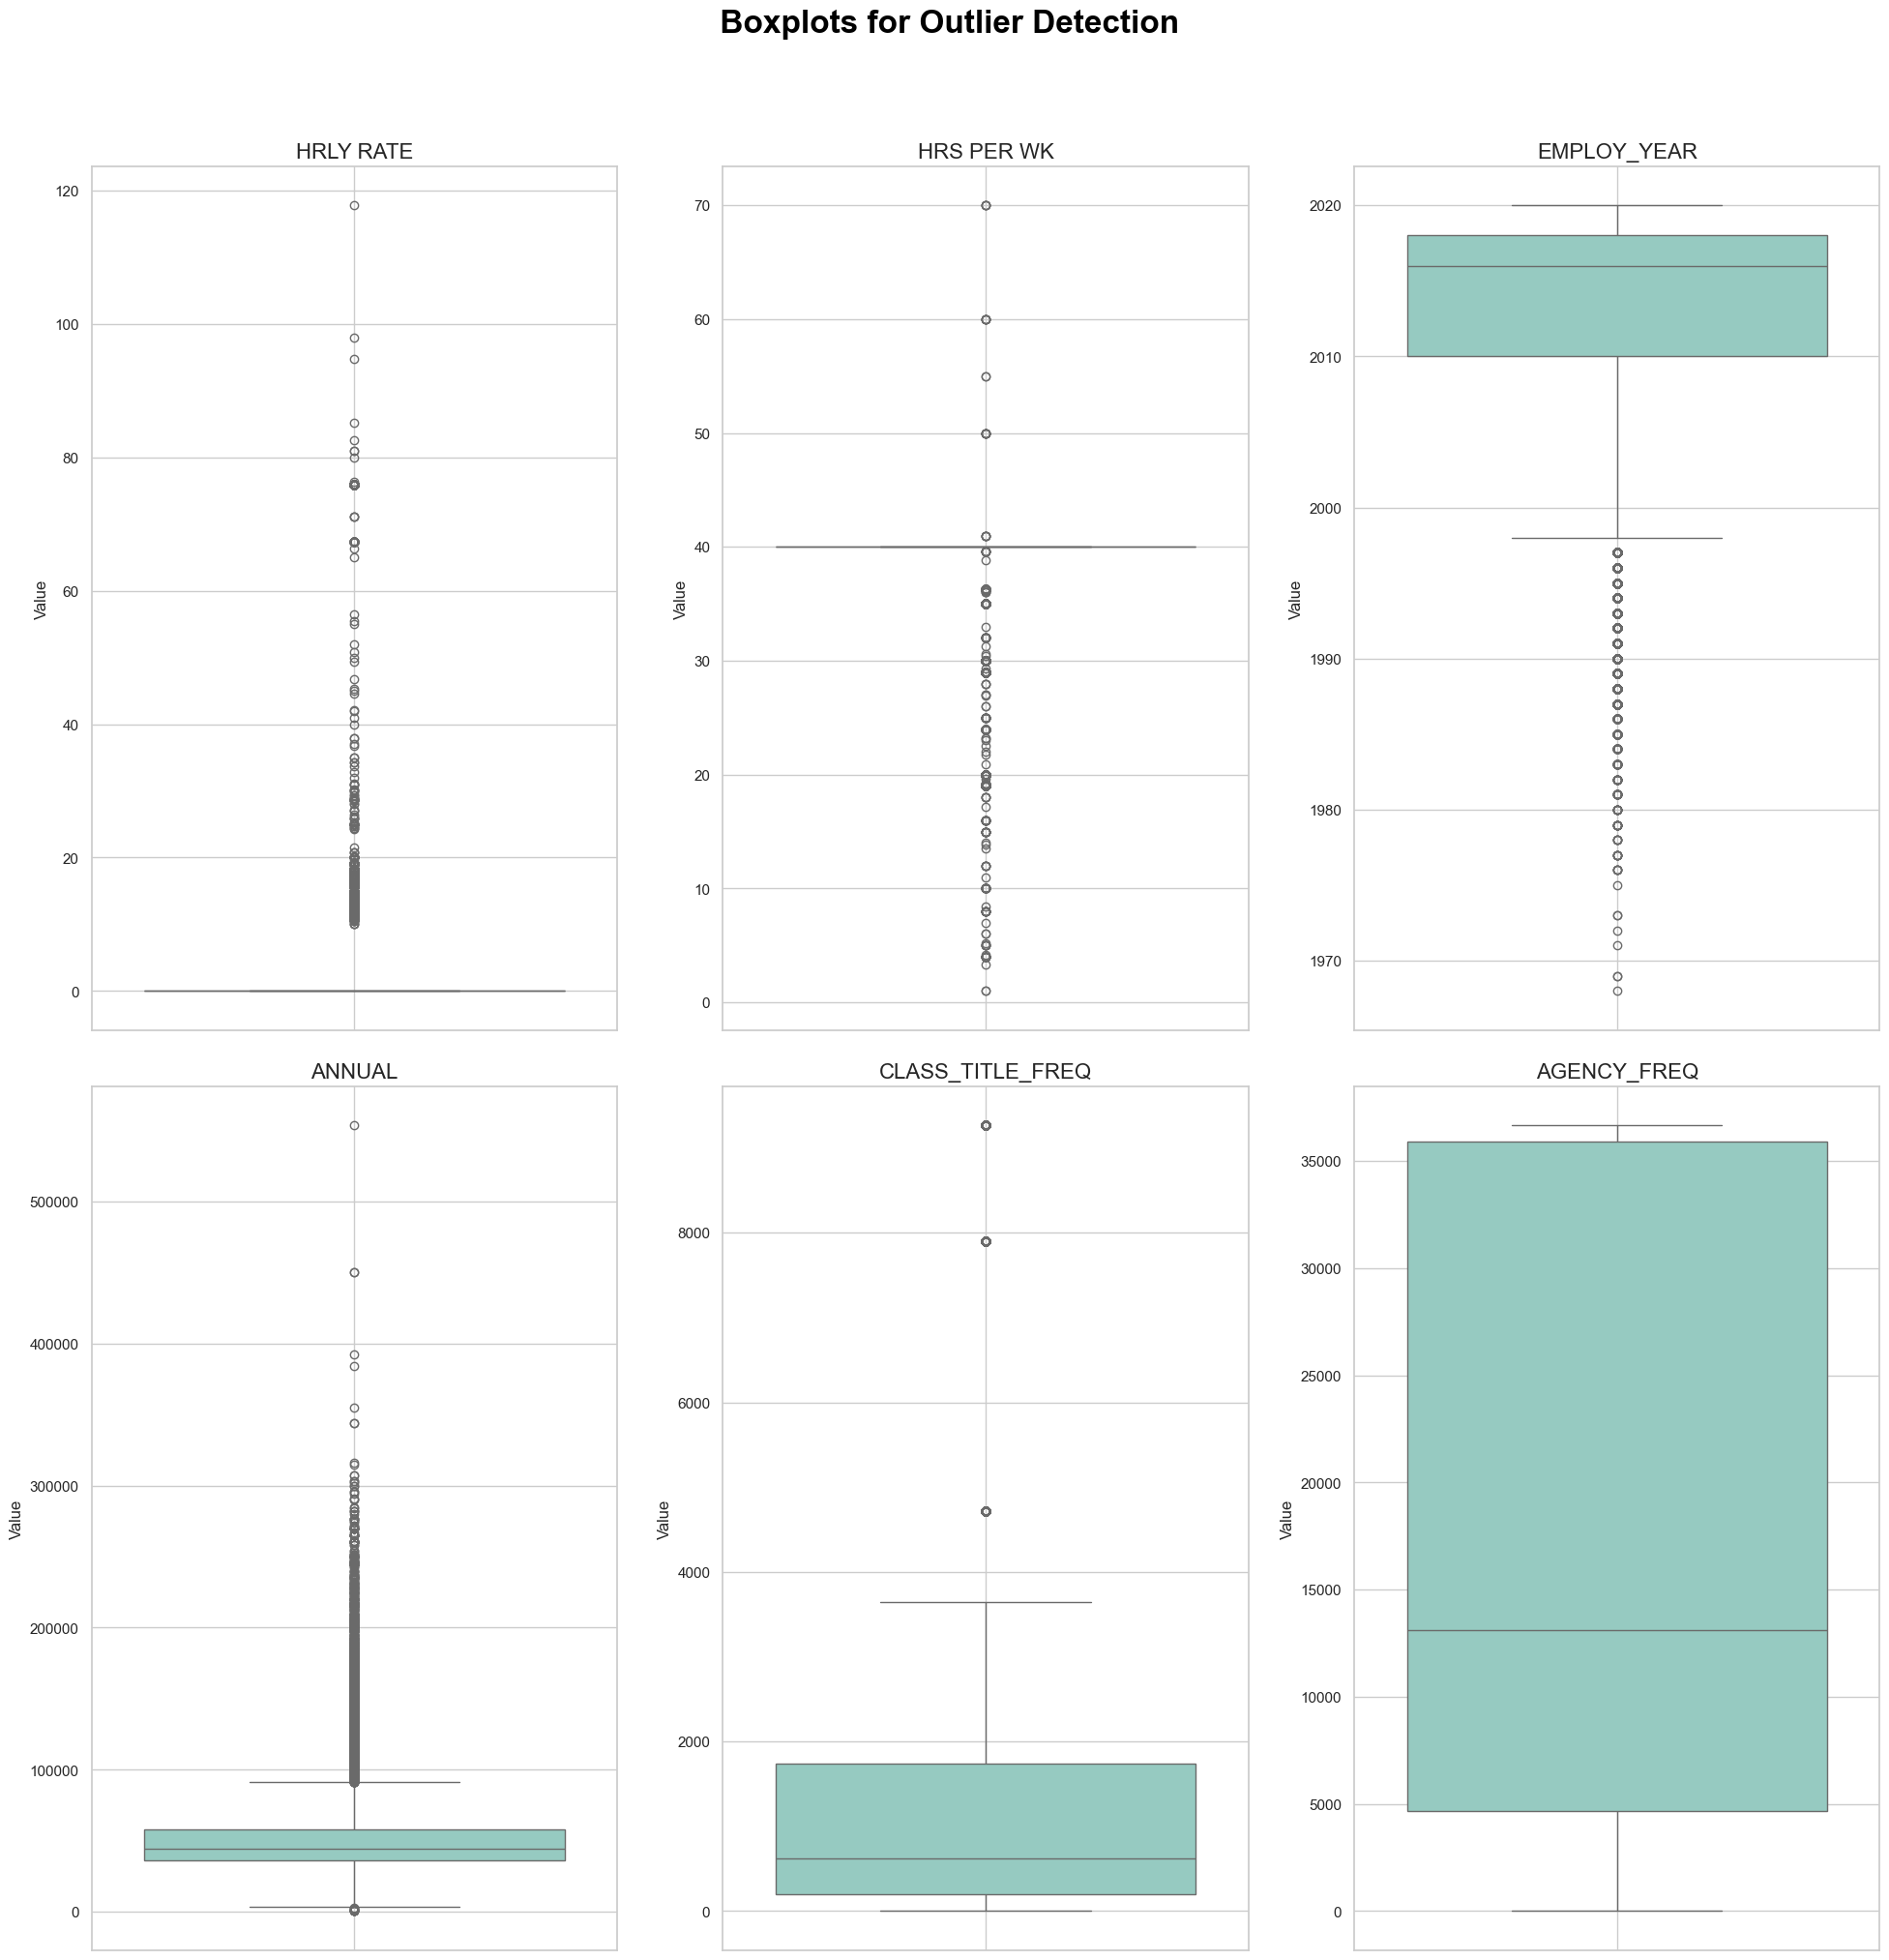

In [16]:
plot_boxplots(df,Num_col)

In [17]:
'''
By checking the outlier's percentage from the outliers_df, 
we will be handling the outliers by IQR based and advance transformation methods to remove outliers.
methods:
1- Winzorize methid (below 5% outliers)
2- log-transformation(above 5% outliers)

'''

"\nBy checking the outlier's percentage from the outliers_df, \nwe will be handling the outliers by IQR based and advance transformation methods to remove outliers.\nmethods:\n1- Winzorize methid (below 5% outliers)\n2- log-transformation(above 5% outliers)\n\n"

In [18]:
Trans_dict = {
    'winz_cols': ['HRLY RATE','HRS PER WK','EMPLOY_YEAR'],
    'log_cols': ['ANNUAL','CLASS_TITLE_FREQ']
}

def winzorize(df, columns):
    df = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df
    
def log_transform(df, columns):
    df = df.copy()
    for column in columns:
        df[column] = df[column].apply(lambda x: np.log1p(x))
    return df

def apply_transformations(df, trans_dict):
    df = df.copy()
    try:
        if 'winz_cols' in trans_dict:
            df = winzorize(df, trans_dict['winz_cols'])
        if 'log_cols' in trans_dict:
            df = log_transform(df, trans_dict['log_cols'])
        return df
    except Exception as e:
        raise Exception(f'Unexpected Exception Occurred: {e}')


In [19]:
df=apply_transformations(df,trans_dict=Trans_dict)

## Creating preprocessing pipeline :

In [20]:
detect_outliers_iqr(df,Num_col)

 Outlier Summary (IQR Method):



,Column,Outlier Count,Outlier Percentage
0,HRLY RATE,0,0.00
1,HRS PER WK,0,0.00
2,EMPLOY_YEAR,0,0.00
3,ANNUAL,4191,2.80
4,CLASS_TITLE_FREQ,1262,0.84
5,AGENCY_FREQ,0,0.00


In [21]:
df

,ETHNICITY,GENDER,STATUS,HRLY RATE,HRS PER WK,ANNUAL,EMPLOY_YEAR,is_hourly,AGENCY_FREQ,CLASS_TITLE_FREQ
0,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,40.0,11.648774,1998,1,1033,5.783825
1,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,0.0,40.0,9.732595,2015,1,266,3.871201
2,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,0.0,40.0,11.648774,2020,1,1033,5.783825
3,WHITE,MALE,CTP - CLASSIFIED TEMPORARY PART-TIME,0.0,40.0,9.732595,2018,1,266,3.871201
4,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.0,40.0,10.581832,2020,0,35926,9.134323
...,...,...,...,...,...,...,...,...,...,...
149476,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.0,40.0,10.457057,2017,0,221,5.955837
149477,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.0,40.0,11.097425,2015,0,221,3.891820
149478,WHITE,MALE,CRP - CLASSIFIED REGULAR PART-TIME,0.0,40.0,9.506601,2012,1,221,5.402677
149479,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,0.0,40.0,11.140860,1998,0,221,6.987490


In [22]:
print(Num_col)

['HRLY RATE', 'HRS PER WK', 'EMPLOY_YEAR', 'ANNUAL', 'CLASS_TITLE_FREQ', 'AGENCY_FREQ']


In [23]:
# Segregating columns for furtjer preprocessing :
OHE_columns=['ETHNICITY','STATUS']
LBE_columns=['GENDER']
SCALING_columns=['HRLY RATE','HRS PER WK','EMPLOY_YEAR','CLASS_TITLE_FREQ', 'AGENCY_FREQ']
PASS_through_cols=['is_hourly']

In [24]:
from sklearn.preprocessing import OrdinalEncoder

In [25]:
preprocessor=ColumnTransformer(
    transformers=[
        ('Label Encoding',OrdinalEncoder(),LBE_columns),
        ('Scaling',StandardScaler(),SCALING_columns),
        ('One Hot Encoding',OneHotEncoder(),OHE_columns),
        ('passyhrough','passthrough',PASS_through_cols)
    ]
)

In [26]:
# Splitting the dataset into training and testing :
x=df.drop(columns='ANNUAL',axis=1)
y=df['ANNUAL']

In [27]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
X_train_preprocessor=preprocessor.fit_transform(X_train)
X_test_preprocessor=preprocessor.transform(X_test)

In [29]:
columns=['GENDER','HRLY RATE','HRS PER WK','EMPLOY_YEAR','AGENCY_FREQ','CLASS_TITLE_FREQ','ETHNICITY_AM INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_OTHER', 'ETHNICITY_WHITE',
'STATUS_CRF - CLASSIFIED REGULAR FULL-TIME', 'STATUS_CRP - CLASSIFIED REGULAR PART-TIME', 'STATUS_CTF - CLASSIFIED TEMPORARY FULL-TIME', 'STATUS_CTP - CLASSIFIED TEMPORARY FULL-TIME', 'STATUS_CTP - CLASSIFIED TEMPORARY PART-TIME', 'STATUS_ERF - EXEMPT REGULAR FULL-TIME', 'STATUS_ERP - EXEMPT REGULAR PART-TIME', 'STATUS_URF - UNCLASSIFIED REGULAR FULL-TIME',
'STATUS_URP - UNCLASSIFIED REGULAR PART-TIME', 'STATUS_UTF - UNCLASSIFIED TEMPORARY FULL-TIME', 'STATUS_UTP - UNCLASSIFIED TEMPORARY PART-TIME',
'is_hourly']
x_train=pd.DataFrame(X_train_preprocessor,columns=columns)
x_test=pd.DataFrame(X_test_preprocessor,columns=columns)

In [30]:
#Save the preprocessed data :
try:
    base_dir = os.path.dirname(os.getcwd()) 
    save_path = os.path.join(base_dir, "data", "preprocessed_data")

    os.makedirs(save_path, exist_ok=True)

    train_df = pd.concat([pd.DataFrame(x_train), y_train.reset_index(drop=True)], axis=1)
    test_df = pd.concat([pd.DataFrame(x_test), y_test.reset_index(drop=True)], axis=1)
    preprocessed_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

    train_df.to_csv(os.path.join(save_path, "train_df.csv"), index=False)
    test_df.to_csv(os.path.join(save_path, "test_df.csv"), index=False)
    preprocessed_df.to_csv(os.path.join(save_path, "preprocessed_df.csv"), index=False)

    print(" All preprocessed files saved successfully!")

except Exception as e:
    print("An error occurred while saving preprocessed files:")
    print(str(e))


 All preprocessed files saved successfully!


# implementing model building with various regression algorithms :

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
os.environ["JOBLIB_MULTIPROCESSING"] = "0"
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

In [39]:
# Check variance of each feature
x_train.var().sort_values()


HRLY RATE                                        0.000000
HRS PER WK                                       0.000000
STATUS_ERP - EXEMPT REGULAR PART-TIME            0.000008
STATUS_CTP - CLASSIFIED TEMPORARY FULL-TIME      0.000008
STATUS_UTF - UNCLASSIFIED TEMPORARY FULL-TIME    0.000059
STATUS_UTP - UNCLASSIFIED TEMPORARY PART-TIME    0.000167
STATUS_CTP - CLASSIFIED TEMPORARY PART-TIME      0.000585
ETHNICITY_AM INDIAN                              0.004736
ETHNICITY_OTHER                                  0.006067
STATUS_ERF - EXEMPT REGULAR FULL-TIME            0.006241
STATUS_URP - UNCLASSIFIED REGULAR PART-TIME      0.006315
STATUS_CTF - CLASSIFIED TEMPORARY FULL-TIME      0.007206
STATUS_CRP - CLASSIFIED REGULAR PART-TIME        0.010213
is_hourly                                        0.011513
STATUS_URF - UNCLASSIFIED REGULAR FULL-TIME      0.015328
ETHNICITY_ASIAN                                  0.027868
STATUS_CRF - CLASSIFIED REGULAR FULL-TIME        0.044439
ETHNICITY_BLAC

In [ ]:
# Model initiliazation as dict :
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)

    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    train_r2 = r2_score(y_train, train_preds)

    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_r2 = r2_score(y_test, test_preds)

    overfit_gap = train_r2 - test_r2

    results.append({
        "Model": name,
        "Train MAE": train_mae,
        "Train RMSE": train_rmse,
        "Train R2": train_r2,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2,
        "Overfit Gap (R2)": overfit_gap
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="Test R2", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


,Model,Train MAE,Train RMSE,Train R2,Test MAE,Test RMSE,Test R2,Overfit Gap (R2)
0,RandomForest,0.045989,0.089329,0.954537,0.078792,0.160056,0.852494,0.102043
1,XGBoost,0.097043,0.164194,0.846402,0.100474,0.174327,0.825016,0.021386
2,DecisionTree,0.030167,0.074950,0.967995,0.087233,0.194495,0.782186,0.185809
3,LightGBM,0.127608,0.201262,0.769223,0.126859,0.202210,0.764564,0.004659
4,GradientBoosting,0.185891,0.272807,0.575984,0.184405,0.272021,0.573938,0.002046
5,Ridge,0.249685,0.333986,0.364481,0.248573,0.333616,0.359140,0.005341
6,LinearRegression,0.249681,0.333985,0.364486,0.248571,0.333617,0.359137,0.005349
7,AdaBoost,0.264846,0.354170,0.285348,0.264726,0.354231,0.277496,0.007853
8,Lasso,0.314417,0.418952,0.000000,0.312444,0.416744,-0.000016,0.000016
9,ElasticNet,0.314417,0.418952,0.000000,0.312444,0.416744,-0.000016,0.000016


## Model Performance Summary :

We trained and evaluated several regression models on the Texas salary dataset. Below is a summary of their performance in terms of Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R² score, and overfitting gap (difference between Train R² and Test R²):

### Key Observations:
- **RandomForest** performed the best overall with a **Train R² of 0.95** and **Test R² of 0.85**, indicating strong generalization ability and high accuracy.
- **XGBoost** and **LightGBM** also showed **competitive performance** with minimal overfit gaps (~0.02 and ~0.005 respectively), making them excellent candidates for further optimization.
- **DecisionTree** model overfits significantly, with a Train R² of ~0.96 and a much lower Test R² (~0.78).
- Linear models such as **Ridge, Lasso, and ElasticNet** performed poorly with low R² scores and are not suitable for this task.
- **GradientBoosting** and **AdaBoost** also underperformed compared to RandomForest and XGBoost.

### Next Steps:
Based on the above evaluation, we will proceed with **hyperparameter tuning** for the following top-performing models:
- `RandomForest`
- `XGBoost`
- `LightGBM`

The goal of tuning is to further improve model generalization and select the best model for final deployment.

We will use **RandomizedSearchCV** or **GridSearchCV** along with **cross-validation** to explore optimal hyperparameter configurations.


## Tunning the model's parameters for better generalization 

In [ ]:
models = {
    'randomforest': RandomForestRegressor(),
    'xgboost': XGBRegressor(),
    'lgbm': LGBMRegressor()
}

def objective(trial, model_name, x_train, y_train, x_test, y_test):
    try:
        if model_name == "randomforest":
            params = {
                "n_estimators": trial.suggest_categorical("n_estimators", [100, 200]),
                "max_depth": trial.suggest_categorical("max_depth", [None, 10]),
                "min_samples_split": trial.suggest_categorical("min_samples_split", [2, 5]),
                "min_samples_leaf": trial.suggest_categorical("min_samples_leaf", [1, 2]),
                "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
                "random_state": 42
            }

        elif model_name == "xgboost":
            params = {
                "n_estimators": trial.suggest_categorical("n_estimators", [100, 200]),
                "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1]),
                "max_depth": trial.suggest_categorical("max_depth", [3, 5, 7]),
                "subsample": trial.suggest_categorical("subsample", [ 0.8, 1.0]),
                "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.8, 1.0]),
                "random_state": 42,
                "tree_method": "hist",
                "n_jobs": 1
            }

        elif model_name == "lgbm":
            params = {
                "n_estimators": trial.suggest_categorical("n_estimators", [100, 200]),
                "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.1]),
                "num_leaves": trial.suggest_categorical("num_leaves", [31, 50]),
                "max_depth": trial.suggest_categorical("max_depth", [-1, 10, 20]),
                "min_child_samples": trial.suggest_categorical("min_child_samples", [20, 30, 50]),
                "random_state": 42,
                "n_jobs": 1
            }

        else:
            raise ValueError("Model not supported.")

        model = models[model_name].__class__(**params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse  
    
    except Exception as e:
        raise Exception(f"Failed during trial for {model_name}: {str(e)}")
        return float('inf')  

In [55]:
results = []
best_params_ = []
tuned_models = {}
for model_name in models:
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, model_name, x_train, y_train, x_test, y_test), n_trials=20)
        best_params = study.best_params
        best_params_.append({'Model': model_name, 'best_params': best_params})

        final_model = models[model_name].__class__(**best_params)
        final_model.fit(x_train, y_train)
        y_pred = final_model.predict(x_test)

        mse = mean_squared_error(y_test, y_pred) 
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": model_name,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

        tuned_models[model_name] = final_model

    except Exception as e:
        raise Exception(f'Exception occured :{e}')

[I 2025-04-26 15:38:27,463] A new study created in memory with name: no-name-4b410b13-d8d8-47f3-bfa6-3ef999ce9b5e
[I 2025-04-26 15:40:26,337] Trial 0 finished with value: 0.03293063317286156 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.03293063317286156.
[I 2025-04-26 15:41:39,439] Trial 1 finished with value: 0.024998000519523066 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.024998000519523066.
[I 2025-04-26 15:42:54,966] Trial 2 finished with value: 0.02547866889575857 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.024998000519523066.
[I 2025-04-26 15:45:08,452] Trial 3 finished with value: 0.06250771360611118 and parameters: {'n_estimators': 200, 'max_depth': 10, '

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:09,029] Trial 0 finished with value: 0.09697003771749314 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 50}. Best is trial 0 with value: 0.09697003771749314.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-04-26 16:35:13,261] Trial 1 finished with value: 0.03268447151045684 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 50}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:19,521] Trial 2 finished with value: 0.0742738945429404 and parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:29,498] Trial 3 finished with value: 0.05863261392050734 and parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 20}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:33,442] Trial 4 finished with value: 0.0742738945429404 and parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:35,029] Trial 5 finished with value: 0.09679891026064097 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 19
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:36,335] Trial 6 finished with value: 0.036087090462566994 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': -1, 'min_child_samples': 20}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:40,023] Trial 7 finished with value: 0.05917218881253431 and parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 30}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:41,686] Trial 8 finished with value: 0.08931773822574653 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 50, 'max_depth': -1, 'min_child_samples': 50}. Best is trial 1 with value: 0.03268447151045684.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:43,411] Trial 9 finished with value: 0.03162864753726987 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': -1, 'min_child_samples': 50}. Best is trial 9 with value: 0.03162864753726987.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:45,180] Trial 10 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:46,758] Trial 11 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:48,650] Trial 12 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:50,766] Trial 13 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:53,326] Trial 14 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:35:57,386] Trial 15 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:36:01,223] Trial 16 finished with value: 0.035957396645025765 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:36:05,073] Trial 17 finished with value: 0.03087180022664604 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 10 with value: 0.03087180022664604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-26 16:36:07,811] Trial 18 finished with value: 0.027883956149890497 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 100, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 18 with value: 0.027883956149890497.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457


[I 2025-04-26 16:36:10,113] Trial 19 finished with value: 0.03082851163488208 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 20, 'min_child_samples': 30}. Best is trial 18 with value: 0.027883956149890497.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 119584, number of used features: 18
[LightGBM] [Info] Start training from score 10.741457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# Summary of all model performances
summary_df = pd.DataFrame(results).sort_values(by="Test MSE", ascending=True)
summary_df

          Model  Test MSE  Test MAE  Test RMSE   Test R2
1       xgboost  0.025002  0.079547   0.158122  0.856037
0  randomforest  0.025090  0.078855   0.158399  0.855532
2          lgbm  0.027884  0.092167   0.166985  0.839445


In [71]:
model=XGBRegressor(**{'n_estimators': 200,
   'learning_rate': 0.2,
   'max_depth': 10,
   'subsample': 1.0,
   'colsample_bytree': 0.8})

In [78]:
import joblib 
try:
    with open('../models/best_model.pkl','wb') as file:
        joblib.dump(model,file)
except Exception as e:
    raise Exception(f'UNexpected error occured: {e}')

## Model Performance After Hyperparameter Tuning

| Model         | Test MSE | Test MAE | Test RMSE | Test R2 |
|---------------|----------|----------|-----------|---------|
| XGBoost       | 0.025002 | 0.079547 | 0.158122  | 0.856037 |
| RandomForest  | 0.025090 | 0.078855 | 0.158399  | 0.855532 |
| LightGBM      | 0.027884 | 0.092167 | 0.166985  | 0.839445 |

### Inferences:
- **XGBoost** achieved the best performance with the highest **R² score (0.8560)** and lowest error metrics, making it the top candidate for deployment.
- **Random Forest** closely follows XGBoost with very similar performance, indicating strong model robustness.
- **LightGBM** also performed well but is slightly behind in terms of R² and error compared to XGBoost and Random Forest.

